In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import datetime as dt
import netCDF4
import numpy as np

In [3]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import MapQuestOpenAerial, MapQuestOSM, OSM

In [4]:
import iris
import pyugrid

In [5]:
iris.FUTURE.netcdf_promote = True

In [6]:
# UMASSD/SMAST FVCOM Simulations in support of Water Quality for MWRA
url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/mwra/fvcom'
var = 'sea_water_salinity'    # use standard_name if it exists
levs = np.arange(28.,33.5,.1)   # contour levels for plotting
bbox = [-71.5, -70, 41.5, 43]
klev = 0   # level 0 is top in FVCOM

# time relative to now
start = dt.datetime.utcnow() + dt.timedelta(hours=6)
# or specific time (UTC)
start = dt.datetime(1998,3,2,15,0,0)

In [7]:
cube = iris.load_cube(url,var)    # Iris uses the standard_name or long_name to access variables

/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/cf.py:552: UserWarning: Missing CF-netCDF formula term variable u'depth', referenced by netCDF variable u'siglev'
  warnings.warn(message % (variable_name, nc_var_name))
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/cf.py:1006: UserWarning: Ignoring variable u'siglay' referenced by variable u'v': Dimensions (u'siglay', u'node') do not span (u'time', u'siglay', u'nele')
  warnings.warn(msg)
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/cf.py:1006: UserWarning: Ignoring variable u'siglay' referenced by variable u'ww': Dimensions (u'siglay', u'node') do not span (u'time', u'siglay', u'nele')
  warnings.warn(msg)
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/cf.py:1006: UserWarning: Ignoring variable u'siglay' referenced by variable u'u': Dimensions (u'siglay', u'node') do not span (u'time', u'siglay', u'nele')
  warnings.warn

In [8]:
ug = pyugrid.UGrid.from_ncfile(url)

cube.mesh = ug
cube.mesh_dimension = 1  # (0:time,1:node)
lon = cube.mesh.nodes[:,0]
lat = cube.mesh.nodes[:,1]
nv = cube.mesh.faces
triang = tri.Triangulation(lon,lat,triangles=nv)

In [9]:
nc = netCDF4.Dataset(url).variables
time_var = nc['time']
itime = netCDF4.date2index(start,time_var,select='nearest')

In [10]:
zcube = cube[itime, klev, :]

## Plot with cool Cartopy tiled background

/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/numpy/lib/shape_base.py:431: FutureWarning: in the future np.array_split will retain the shape of arrays with a zero size, instead of replacing them by `array([])`, which always has a shape of (0,).
  FutureWarning)
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


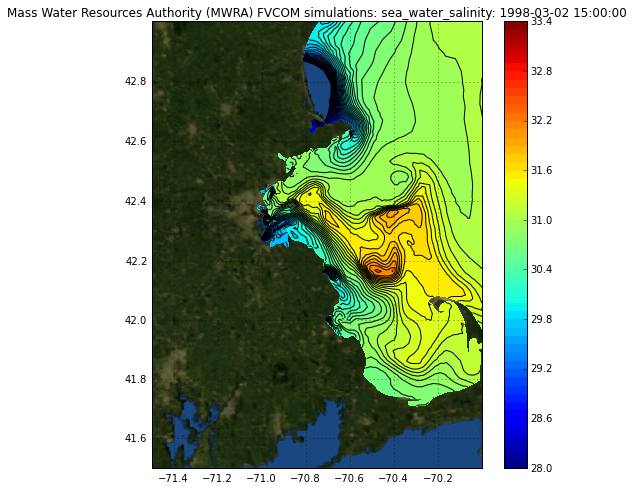

In [11]:
geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))

fig = plt.figure(figsize=(8,8))
tiler = MapQuestOpenAerial()
ax = plt.axes(projection=tiler.crs)

#ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(bbox,geodetic)
ax.add_image(tiler, 8)

#ax.coastlines()
plt.tricontourf(triang, zcube.data, levels=levs, transform=geodetic)
plt.colorbar()
plt.tricontour(triang, zcube.data, colors='k',levels=levs, transform=geodetic)
tvar = cube.coord('time')
tstr = tvar.units.num2date(tvar.points[itime])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.title('%s: %s: %s' % (zcube.attributes['title'],var,tstr));